# Handling Missing Values in the Ames Housing Dataset

Overview: 
The Ames Housing dataset describes individual residential properties that were sold in Ames, Iowa from 2006 to 2010. The Dataset contains 79 explonatory variables describing a features and properties of the houses sold or conditions of the sale and an 80th dependent variable as sale price. Numerous catagorical and continous variables in the dataset contain missing values. This notebook uses data exploration, feature engineering, simple imputations and multivariate imputation to clean and fill in the missing values in the Ames Housing dataset.
The Ames Housing Dataset is part of a Kaggle competition. The competition and the dataset can be found here: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview

In [1]:
# Import python packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from scipy import stats
%matplotlib inline

In [2]:
# Import dataset
dataset = pd.read_csv('train.csv', index_col = 'Id')

In [3]:
# Explore column names and datatypes
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

In [4]:
# A quick glance at the info on the dataset shows that there a numerous columns with missing values
# looking more closely at the missing values
tot_missdata = dataset.isnull().sum().sort_values(ascending=False)
percent_miss = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
data_type = dataset.dtypes
missing_data = pd.concat([tot_missdata, percent_miss, data_type], axis=1, join = 'inner', keys=['tot_missdata', 'percent_miss', 'data type'])
missing_data.head(20)

,tot_missdata,percent_miss,data type
PoolQC,1453,0.995205,object
MiscFeature,1406,0.963014,object
Alley,1369,0.937671,object
Fence,1179,0.807534,object
FireplaceQu,690,0.472603,object
LotFrontage,259,0.177397,float64
GarageType,81,0.055479,object
GarageCond,81,0.055479,object
GarageFinish,81,0.055479,object
GarageQual,81,0.055479,object


 NA values in excel automatically get converted to nan values in Anaconda. Therefore missing values in Anaconda are not nesserarily missing. Looking at the documentation they often indicate the absence of a feature.

Features where NA in the original excel sheet indicates the non-existence of a feature are:
- Alley - no alley access
- BsmtQual - no basement 
- BsmtCond - no basement
- BsmtExposure - no basement
- BsmtFinType1 - no basement
- BsmtFinType2 - no basement
- FireplaceQu - no fireplace
- GarageType - no garage
- GarageFinish - no garage
- GarageQual - no garage
- GarageCond - no garage
- PoolQC - no pool
- Fence - no fence
- MiscFeature - none

Data for these variables cannot be counted as missing as the NA values do provide information about the house. The nan values for these variables will
be changed to none so these missing values can become their own catagory.

In [5]:
# Copy dataset
adj_dataset = dataset.copy()

In [6]:
# list of catagorical variables whose nan values represent the non-existance of a feature
miss_feature_list = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                     'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

# Replace rest of the object variables nan values with 'none'
adj_dataset[miss_feature_list] = adj_dataset[miss_feature_list].fillna('none')

In [7]:
# Re-inspect missing values in dataset
tot_missdata = adj_dataset.isnull().sum().sort_values(ascending=False)
percent_miss = (adj_dataset.isnull().sum()/adj_dataset.isnull().count()).sort_values(ascending=False)
data_type = adj_dataset.dtypes
missing_data = pd.concat([tot_missdata, percent_miss, data_type], axis=1, join = 'inner', keys=['tot_missdata', 'percent_miss', 'data type'])
missing_data.head(20)

,tot_missdata,percent_miss,data type
LotFrontage,259,0.177397,float64
GarageYrBlt,81,0.055479,float64
MasVnrType,8,0.005479,object
MasVnrArea,8,0.005479,float64
Electrical,1,0.000685,object
SalePrice,0,0.000000,int64
Foundation,0,0.000000,object
RoofMatl,0,0.000000,object
Exterior1st,0,0.000000,object
Exterior2nd,0,0.000000,object


This leaves the following variables with missing values:
- LotFrontage
- GarageYrBlt
- MasVnrArea
- MassVnrType
- Electrical

In [8]:
# Taking care of Electrical, MassVnrType by filling in missing values with most common value

# Electrical
mode_electrical = adj_dataset['Electrical'].value_counts().index[0]
adj_dataset['Electrical'] = adj_dataset['Electrical'].fillna(mode_electrical)

# MasVnrType
mode_MasVnrType = adj_dataset['MasVnrType'].value_counts().index[0]
adj_dataset['MasVnrType'] = adj_dataset['MasVnrType'].fillna(mode_MasVnrType)


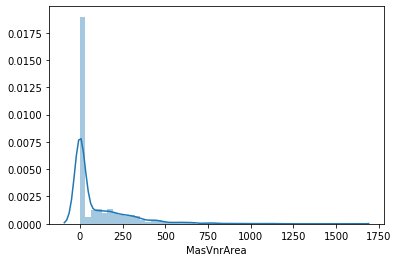

In [9]:
# Now looking at MasVnrArea

# look at its distribution plot
sns.distplot(adj_dataset['MasVnrArea'])

In [10]:
# From the dispersion diagram, zero is clearly the most commonly occuring value with the mode and median both at zero. The mode will be used to impute the
# missing values
adj_dataset['MasVnrArea'] = adj_dataset['MasVnrArea'].fillna(0)

Remaining missing variables are LotFrontage and GarageYrBuilt. To determine how to impute these missing variables, relationships between the variables in the dataset will be explored 

In [11]:
# Read through the documentation provided. The variables can be split into three different types: continuous, nominal and ordinal


# cata_vars list is a list of the nominal variables
cata_vars = ['MSSubClass','MSZoning', 'Street', 'Alley', 'LotConfig',
             'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
             'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
             'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating',
             'Electrical', 'GarageType', 'PavedDrive', 'MiscFeature',
             'SaleType', 'SaleCondition']

# ordinal_vars is a list of all the ordinal variables both variables that have been already been converted to numeric and ordinal variables still
# in string form
ordinal_vars =['LotShape', 'LandContour', 'Utilities',
              'LandSlope','OverallQual', 'OverallCond',
              'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
              'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
              'HeatingQC', 'CentralAir','KitchenQual', 'Functional',
              'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
              'Fence']

# Exclusive list of ordinal variables still in string form
str_ordinals = ['LotShape', 'LandContour', 'Utilities', 
               'LandSlope', 'ExterQual', 'ExterCond', 
               'BsmtQual', 'BsmtCond',  'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
               'HeatingQC', 'CentralAir','KitchenQual','Functional',
               'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
              'Fence'] 

# Ordinal variables already in numberic form
numeric_ordinals = ['OverallQual', 'OverallCond']

In [12]:
# str_ordinals will be encoded into numeric form so they can be included in the correlation matrix
label_encoder = LabelEncoder()
for col in str_ordinals:
    adj_dataset[col] = label_encoder.fit_transform(adj_dataset[col])

In [13]:
# Reinspect the datatypes 
adj_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            1460 non-null object
LotShape         1460 non-null int32
LandContour      1460 non-null int32
Utilities        1460 non-null int32
LotConfig        1460 non-null object
LandSlope        1460 non-null int32
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-nu

In [14]:
# look at correlations of the continous and ordinal data with SalePrice (dependent variable)
corrmatrix = adj_dataset.corr()
# Search for highest correlations to SalePrice
salescorr = corrmatrix['SalePrice'].abs()
salescorr = salescorr.to_frame()
salescorr = salescorr.sort_values(by = 'SalePrice', ascending = False)
print(salescorr)

               SalePrice
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
ExterQual       0.636884
GarageArea      0.623431
BsmtQual        0.620886
TotalBsmtSF     0.613581
1stFlrSF        0.605852
KitchenQual     0.589189
FullBath        0.560664
GarageFinish    0.549247
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.472614
Fireplaces      0.466929
FireplaceQu     0.459605
HeatingQC       0.400178
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
BsmtExposure    0.309043
HalfBath        0.284108
LotArea         0.263843
LotShape        0.255580
CentralAir      0.251328
BsmtFullBath    0.227122
BsmtUnfSF       0.214479
BedroomAbvGr    0.168213
Fence           0.140640
KitchenAbvGr    0.135907
EnclosedPorch   0.128578
PoolQC          0.126070
ExterCond       0.117303
Functional      0.115328


Reading through the documentation of the explonatory variables a number of data issues were found:
1) TotalBsmtSF is made up of BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF

2) GrLivArea = 1stFlrSF + 2ndFlrSF + LowQualFinSF

3) BedroomAbvGr and KitchenAbvGr are included in TotRmsbvGrd

To resolve these issues TotalBsmtSF will be removed, BsmtFinSF1 and BsmFinSF2 will be added together and BsmtUNSF will be kept on its own. As well, GrLivArea will removed, 1stFlrSF and 2ndFlrSF will be added together but LowQualFinSF will be kept on its own. Finally, BedroomAbvGr will be removed, KitchenAbGr substracted from TotRmsbvGr and TotalRmsAbvGrd will become LivnRmsAbvGrd.

Logic: Total BsmtSF is an important predictor while each of the components are not. I do not want to loose the importance of TotalBsmtSF however BsmtUnfSF is different from finished basement types so they should be kept seperate. Same logic for GridLivAre. GridLivArea is an important predictor while its components are not. I do not want to loose all the importance of this GrLivArea so 1stFlrSF and 2ndFlrSf are the closely related to one another but LowQualFinSF should be on its own as it is a different type of finish. Lastly bedrooms included in TotRmsbvGrd but not as important as TotRmsbrGrd so BedroomAvGr will be removed.

In [15]:
# Changing the dataset based on comments
adj_dataset['GqualGrLivArea'] = adj_dataset['1stFlrSF'] + adj_dataset['2ndFlrSF']
adj_dataset['GqualBsmtSF'] = adj_dataset['BsmtFinSF1'] + adj_dataset['BsmtFinSF2']
adj_dataset['LivnRmsAbGr'] = adj_dataset['TotRmsAbvGrd'] - adj_dataset['KitchenAbvGr']
adj_dataset = adj_dataset.drop(columns = ['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'TotRmsAbvGrd',
                                         'TotalBsmtSF', 'GrLivArea', 'BedroomAbvGr'])

In [16]:
# Find highly correlated coefficients with a collinearity of .7 to .9 - looking for data that can be excluded from the model in order to increase 
# interpretability of the model as well as reduce the noise in the dataset. 
adj_corrmatrix = adj_dataset.corr()
s = adj_corrmatrix.unstack()
so = s.sort_values(ascending = False)
so = so.to_frame()

# Looking for variables with correlation greater than or equal to .7
corrvalues = so[(so[0] <1) & (so[0] >= .7)].drop_duplicates()
corrvalues
# High correlations with sales prices are desriable and will be ignored here

0
GarageCars  GarageArea      0.882475
LivnRmsAbGr GqualGrLivArea  0.827912
GarageYrBlt YearBuilt       0.825667
SalePrice   OverallQual     0.790982
            GqualGrLivArea  0.716883

GarageCars and GarageArea are providing very similiar information. 
Looking at the data description in the documentation:
- GarageCars: Size of garage in car capacity
- GarageArea: Size of garage in square feet

To reduce collinearity, GarageCars will be kept and GarageArea will be deleted as GarageCars has a stronger relationship with SalePrice.
As well, GarageYrBlt will be deleted since it is redundant to year built.

In [17]:
adj_dataset = adj_dataset.drop(columns = ['GarageArea'])
adj_dataset = adj_dataset.drop(columns = ['GarageYrBlt'])

GqualGrLivArea and LivnRmsAbGr are the second most highly correlated. Originally I multiplied the two variables as shown:

adj_dataset['TotalGrLivScore'] = adj_dataset['GqualGrLivArea'] * adj_dataset['LivnRmsAbGr']

However, combining these variables increased all the mean squared error scores in the last section of this notebook. As well, deleting one of these variables has also increased all the mean squared error scores in the last section of this notebook. Therefore I have left these two variables alone.


In [18]:
# Re-inspect again to ensure that LotFrontage is now the only missing variable
tot_missdata = adj_dataset.isnull().sum().sort_values(ascending=False)
percent_miss = (adj_dataset.isnull().sum()/adj_dataset.isnull().count()).sort_values(ascending=False)
data_type = adj_dataset.dtypes
missing_data = pd.concat([tot_missdata, percent_miss, data_type], axis=1, join = 'inner', keys=['tot_missdata', 'percent_miss', 'data type'])
missing_data.head(10)

,tot_missdata,percent_miss,data type
LotFrontage,259,0.177397,float64
LivnRmsAbGr,0,0.000000,int64
ExterQual,0,0.000000,int32
RoofStyle,0,0.000000,object
RoofMatl,0,0.000000,object
Exterior1st,0,0.000000,object
Exterior2nd,0,0.000000,object
MasVnrType,0,0.000000,object
MasVnrArea,0,0.000000,float64
ExterCond,0,0.000000,int32


In [19]:
# LotFrontage is indeed the only variable left with missing values
# Before moving on to part 2 of this notebook first SalePrice will be isolated and removed from the adj_dataset
SalePrice = adj_dataset['SalePrice']
adj_dataset = adj_dataset.drop(columns = ['SalePrice'])

## Part 2. Handling Missing Values in the LotFrontage Variable

LotFrontage is the most concerning as it is missing a significant amount of data (approx 18 %) first I will need to see if the data is missing completely at random (MCA). However, before testing if the data is missing completely at random, it has to be determined if the continous and ordinal data is normally distributed in order to choose an appropriate test for determining if data is missing completely at random.

#### 1. Determine if continous and ordinal data is normally distributed

The data distribution types will determine which statisitcal tests can be used to see if the data is missing completly at random

In [20]:
# Isolate the numeric variables

float_data = (adj_dataset.dtypes == 'float64')
float_cols = list(float_data[float_data].index)
int64_data = (adj_dataset.dtypes == 'int64')
int64_cols = list(int64_data[int64_data].index)
int32_data =(adj_dataset.dtypes == 'int32')
int32_cols =list(int32_data[int32_data].index)
numeric_cols = float_cols + int64_cols + int32_cols

In [21]:
# Convert LotFrontage into two variables - missing and not missing then drop the numeric LotFrontage
norm_dataset = adj_dataset.copy()
norm_dataset['missing'] = norm_dataset['LotFrontage'].isnull()
norm_dataset['missing'] = norm_dataset['missing'].astype(int)
norm_dataset = norm_dataset.drop(columns = ['LotFrontage'])

mask_notmissing = norm_dataset['missing'] == 0
mask_missing = norm_dataset['missing'] == 1

In [22]:
# Remove LotFrontage from numeric_cols before continuing 
numeric_cols.remove('LotFrontage')


In [23]:
# Set alpha to be used in all the distribution tests
alpha = .05

In [24]:
# Testing for normality of continous and ordinal variables connected with missing values of LotFrontage

miss_normstatus= []
norm_names = []

for y in numeric_cols:    
    stat, p_norm  = scipy.stats.normaltest(norm_dataset[y][mask_missing])
    norm_names.append(y)
    if p_norm > alpha:  # null hypothesis: x comes from a normal distribution
        miss_normstatus.append("y is normally distributed (fail to reject H0)")
    else:
        miss_normstatus.append("y is not normally distributed (reject H0)")

In [25]:
# Testing for normality of continous and ordinal variables connected with non-missing values of LotFrontage

nmiss_normstatus= []

for y in numeric_cols:    
    stat, p_norm  = scipy.stats.normaltest(norm_dataset[y][mask_notmissing])
    if p_norm > alpha:  # null hypothesis: x comes from a normal distribution
        nmiss_normstatus.append("y is normally distributed (fail to reject H0)")
    else:
        nmiss_normstatus.append("y is not normally distributed (reject H0)")

In [26]:
# Put results in a dataframe
        
norm_results = {'variable' : norm_names,
                'normality missing obs' : miss_normstatus,
                'normality observed obs' : nmiss_normstatus}

norm_results = pd.DataFrame(norm_results, columns = ['variable', 
                                                     'normality missing obs', 
                                                     'normality observed obs'])
norm_results

,variable,normality missing obs,normality observed obs
0,MasVnrArea,y is not normally distributed (reject H0),y is not normally distributed (reject H0)
1,MSSubClass,y is not normally distributed (reject H0),y is not normally distributed (reject H0)
2,LotArea,y is not normally distributed (reject H0),y is not normally distributed (reject H0)
3,OverallQual,y is normally distributed (fail to reject H0),y is not normally distributed (reject H0)
4,OverallCond,y is not normally distributed (reject H0),y is not normally distributed (reject H0)
5,YearBuilt,y is not normally distributed (reject H0),y is not normally distributed (reject H0)
6,YearRemodAdd,y is not normally distributed (reject H0),y is not normally distributed (reject H0)
7,BsmtUnfSF,y is not normally distributed (reject H0),y is not normally distributed (reject H0)
8,LowQualFinSF,y is not normally distributed (reject H0),y is not normally distributed (reject H0)
9,BsmtFullBath,y is not normally distributed (reject H0),y is not normally distributed (reject H0)


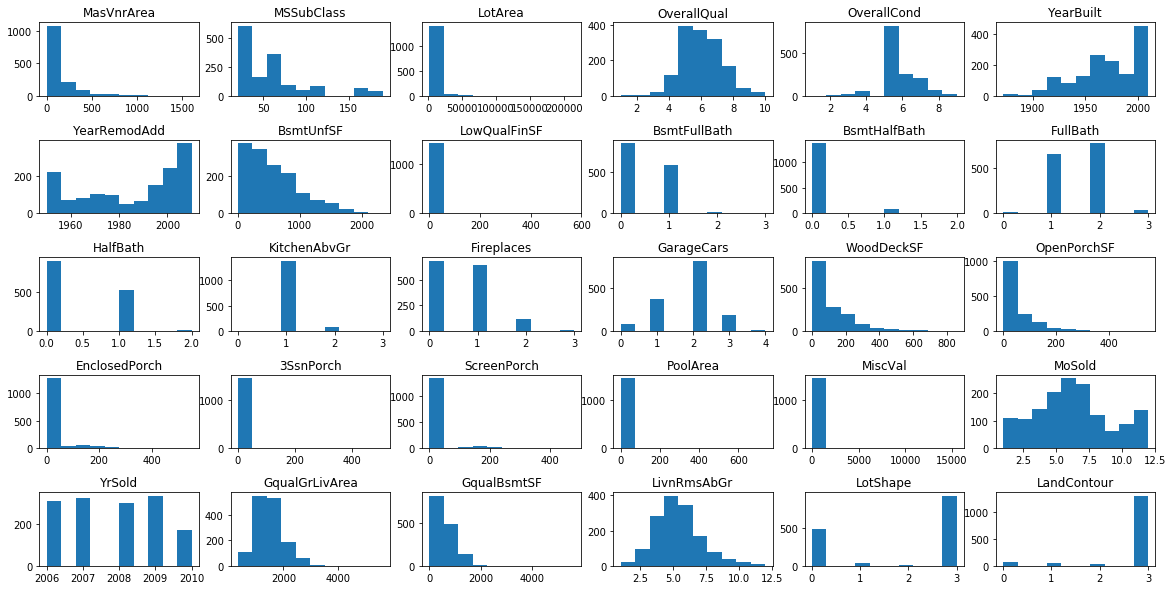

In [27]:
# Okay almost all the checked variables are not normally distributed lets varify with some plots

fig = plt.figure(figsize=(20,10))
for y, num in zip(numeric_cols, range(1,31)):
    ax = fig.add_subplot(5,6,num)   
    x = norm_dataset[y]
    ax = plt.hist(x)
    plt.title(y)
    plt.subplots_adjust(hspace=.6)

plt.show()

Looking at the test results and at the distribution plot we see that the variables are not normally distributed. Therefore a Mann-Whitney test will be used for the ordinal and continous data to test for distribution independence between missing LotFrontage data and not missing LotFrontage data.

#### 2. Using Man Whitney Test if Missing and Non Missing LotFrontage Distributions are the Same for Continous and Ordinal Data

In [28]:
# Man Whitney test
mw_status= []
mw_names = []

for y in numeric_cols:
    mw_stat, mw_p = scipy.stats.mannwhitneyu(norm_dataset[y][mask_missing], 
                                             norm_dataset[y][mask_notmissing])
    mw_names.append(y)
    if mw_p > alpha:  # alpha here is is .05
        mw_status.append("same distribution (fail to reject H0)")
    else:
        mw_status.append("different distributions (reject H0)")

mw_data = {'variable' : mw_names,
            'status': mw_status
        }

mw_results = pd.DataFrame(mw_data, columns = ['variable', 'status'])

In [29]:
mw_results

,variable,status
0,MasVnrArea,different distributions (reject H0)
1,MSSubClass,same distribution (fail to reject H0)
2,LotArea,different distributions (reject H0)
3,OverallQual,same distribution (fail to reject H0)
4,OverallCond,same distribution (fail to reject H0)
5,YearBuilt,same distribution (fail to reject H0)
6,YearRemodAdd,different distributions (reject H0)
7,BsmtUnfSF,different distributions (reject H0)
8,LowQualFinSF,same distribution (fail to reject H0)
9,BsmtFullBath,different distributions (reject H0)


From the results we can see that LotFrontage data is not missing completly at random. Many of the variables have different distributions depending on whether LotFrontage is missing or not 

#### 3. Test of Independence for Nominal Data using Chi-Squared Statistic

A chi-square test will be used to determine if the missing LotFrontage and non missing LotFrontage data distributions are the same depending on each nominal variable.

In [30]:
chi_dataset = adj_dataset.copy()
# Columns to be kept - append the LotFrontage to chi_cols
chi_cols = cata_vars.copy()
chi_cols.append('LotFrontage')
# select chi_cols from the chi_dataset - only want to work with nominal variables + LotFrontage
chi_dataset = chi_dataset[chi_cols]

# Create columns of true or false depending on if LotFrontage is missing
chi_dataset['missing'] = chi_dataset['LotFrontage'].isnull()

# Change true or false to zeros and ones
chi_dataset['missing'] = chi_dataset['missing'].astype(int)

# Drop LotFrontage from data set
chi_dataset = chi_dataset.drop(columns = ['LotFrontage'])


In [31]:
# Run chi-squared test for each nominal variable

status_list = []
name_list = []
prob = 0.95
for y in cata_vars:
    x = pd.crosstab(chi_dataset['missing'], chi_dataset[y])
    stat, p, dof, ex = scipy.stats.chi2_contingency(x)
    name_list.append(y)
    critical = scipy.stats.chi2.ppf(prob, dof)
    if abs(stat) >= critical:
        status_list.append('Dependent (reject H0)')
    else:
	    status_list.append('Independent (fail to reject H0)')

In [32]:
# Create and show dataframe of results

chi_data = {'variable' : name_list,
            'status': status_list
        }

chi_results = pd.DataFrame(chi_data, columns = ['variable', 'status'])
chi_results

,variable,status
0,MSSubClass,Dependent (reject H0)
1,MSZoning,Dependent (reject H0)
2,Street,Independent (fail to reject H0)
3,Alley,Dependent (reject H0)
4,LotConfig,Dependent (reject H0)
5,Neighborhood,Dependent (reject H0)
6,Condition1,Dependent (reject H0)
7,Condition2,Independent (fail to reject H0)
8,BldgType,Independent (fail to reject H0)
9,HouseStyle,Dependent (reject H0)


The results show that whether LotFrontage is missing or not is not independent of the status of many of the nominal variables.

Given that wheter LotFrontage is missing is shown to be influenced by many of the variables in the dataset, the missing data in LotFrontage will be imputed using the other variables in the dataset in section 4 below.

#### 4. Comparing Results of Imputed LotFrontage Values with Simple Imputation and Multivariate Imputation

In [33]:
# Encode rest of dataset
# NOTE - for nominal catagorical it is more theorically accurate to use dummy encoding, however calculating LotFrontage from other variables after dummy
# encoding causes the mean square error values from this form of imputation to be three times greater than simple imputation. 
# Tis is likely because dummy encoding in this dataset creates over 100 new variables which causes dimensionality problems.

label_encoder = LabelEncoder()
for col in cata_vars:
    adj_dataset[col] = label_encoder.fit_transform(adj_dataset[col])

# make sure all variables are now numerical    
adj_dataset.dtypes

MSSubClass          int64
MSZoning            int32
LotFrontage       float64
LotArea             int64
Street              int32
Alley               int32
LotShape            int32
LandContour         int32
Utilities           int32
LotConfig           int32
LandSlope           int32
Neighborhood        int32
Condition1          int32
Condition2          int32
BldgType            int32
HouseStyle          int32
OverallQual         int64
OverallCond         int64
YearBuilt           int64
YearRemodAdd        int64
RoofStyle           int32
RoofMatl            int32
Exterior1st         int32
Exterior2nd         int32
MasVnrType          int32
MasVnrArea        float64
ExterQual           int32
ExterCond           int32
Foundation          int32
BsmtQual            int32
                   ...   
FullBath            int64
HalfBath            int64
KitchenAbvGr        int64
KitchenQual         int32
Functional          int32
Fireplaces          int64
FireplaceQu         int32
GarageType  

#### Mean Squared Error From Simple Imputation

In [34]:
# Calculate MSE with simple imputation using the median

median_LotFrontage = adj_dataset['LotFrontage'].median()

SI_dataset1 = adj_dataset.copy()
SI_dataset1['LotFrontage'] = SI_dataset1['LotFrontage'].fillna(median_LotFrontage)

regressor = ExtraTreesRegressor(n_estimators=100, max_depth = 55, random_state=0)
si_scores_m = cross_val_score(
            regressor, SI_dataset1, SalePrice, scoring='neg_mean_squared_error',
            cv=5
        )

si_score_median = abs(si_scores_m.mean()) 
si_score_median

954713272.924414

In [35]:
# Calculate MSE with simple imputation using the mean

mean_LotFrontage = adj_dataset['LotFrontage'].mean()

SI_dataset2 = adj_dataset.copy()
SI_dataset2['LotFrontage'] = SI_dataset2['LotFrontage'].fillna(mean_LotFrontage)
mean_si_scores = cross_val_score(
            regressor, SI_dataset2, SalePrice, scoring='neg_mean_squared_error',
            cv=5
        )
si_score_mean = abs(mean_si_scores.mean())  
si_score_mean

939727700.8959653

#### Mean Squared Error From Multivariate Imputation

In [36]:
# Using all the explonatory variable in the dataset for the multivariate imputation - it yields the best results

mi_dataset = adj_dataset.copy()


In [37]:
# Get list of column names to be used for later
mi_names = list(mi_dataset.columns.values)

In [38]:
# Using IterativeImputer and ExtraTreesRegressor from Sklearn

estimator = ExtraTreesRegressor(n_estimators=100, max_depth = 30, random_state=0)
imp = IterativeImputer(estimator = estimator, max_iter=10, random_state=0)
imp.fit(mi_dataset)
mi_dataset = pd.DataFrame(imp.transform(mi_dataset))

In [39]:
# Put back columnn names
mi_dataset.columns = mi_names 

In [40]:
# Extract the imputed lotfrontage column
MiLotFrontage = pd.DataFrame(mi_dataset['LotFrontage'])
MiLotFrontage.index +=1

In [41]:
# Compute the MSE for the dataset from imputed LotFrontage calculated using multivariate imputation

mi_dataset2 = adj_dataset.copy()
mi_dataset2['imp_LotFrontage'] = MiLotFrontage
mi_dataset2 = mi_dataset2.drop(columns = ['LotFrontage'])

mi_scores = cross_val_score(
            regressor, mi_dataset2, SalePrice, scoring='neg_mean_squared_error',
            cv=5
        )
mi_score_mean = abs(mi_scores.mean())  
mi_score_mean

934729341.2477849

## Conclusion

It can be seen that multivariate imputation yields imputed LotFrontage values which will then predict SalePrice more accurately than simple imputation of the mean and median. This dataset is now free of missing values from using a combination of imputation, logical thinking and reading through the documentation. The dataset is now ready for additional data exploration such as looking for outliers, feature engineering, feature selection and model building.